#### Import potrzebnych bibliotek

In [41]:
# for loading data
import pandas as pd
import numpy as np
import random
import time

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# methods typing
from typing import List, Dict

import math
import requests
from bs4.element import NavigableString as navigable
from bs4 import BeautifulSoup

#### Funkcje pomocnicze

In [31]:
def get_stops(line_num = 139, direction = 2):
    cookies = {'ROZKLADY_AB': '0', 'ROZKLADY_JEZYK': 'PL', 'ROZKLADY_OSTATNIA': '1595799914', 'ROZKLADY_WIDTH': '2000', 'ROZKLADY_WIZYTA': '3'}
    base_url = 'http://rozklady.mpk.krakow.pl/?lang=PL&akcja=index&rozklad=20200727&linia='
    content = requests.get(base_url+str(line_num)+'__'+str(direction), cookies=cookies).text    
    ordered_stops = []
    
    if "table style=' '" not in content:
        content = requests.get(base_url+str(line_num)+'__1', cookies=cookies).text
    
    soup = BeautifulSoup(content)
    for content in soup.select('table[style=" "]')[0].contents:
        if isinstance(content, navigable):
            continue
        try:
            stop = content.contents[1].contents[1].contents[1].text.strip()
            if content.contents[5].text.strip() == 'NŻ':
                stop += ' (nż)'
            ordered_stops.append(stop)
        except:
            ordered_stops.append(content.contents[1].contents[0].strip())
    return ordered_stops

def data_stats(df: pd.DataFrame) -> pd.DataFrame:
    data_stats = df.select_dtypes(['float','int', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32'])
    data_stats = data_stats.describe()
    data_stats = data_stats.transpose()
    data_stats['std'] = round(data_stats['std'],2)
    data_stats['mean'] = round(data_stats['mean'],2)
    data_stats['dtype'] = df.dtypes
    return data_stats


def display_correlations(df: pd.DataFrame, x: int = 12, y: int = 12) -> plt.figure:
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(x, y))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

def remove_outliers(df: pd.DataFrame, columns: List[str], error_discriminator: float = 1.5) -> pd.DataFrame:
    for column in columns:
        q1 = df[column].describe()['25%']
        q3 = df[column].describe()['75%']
        iqr = q3 - q1
        df = df[df[column] > q1 - error_discriminator * iqr]
        df = df[df[column] < q3 + error_discriminator * iqr]
    return df

        
def histograms(df: pd.DataFrame, columns: List[str], height: int = 12, width: int = 12, 
               n_cols: int = 2, kde: bool = False, hist: bool = True, 
               color: str = "b", multi_plot: bool = False) -> plt.figure:
    if len(columns) == 1:
        plt.figure(figsize=(width, height))
        sns.distplot(df[columns[0]], kde=kde, hist=hist, color=color, label=column)
        plt.show()
        return
    if not multi_plot:
        plt.figure(figsize=(width, height))
        for column in columns:
            sns.distplot(df[columns], kde=kde, hist=hist, label=column)
        plt.show()
    
    f, axes = plt.subplots(math.ceil(len(columns) / n_cols), n_cols, figsize=(width, height), sharex=True)
    sns.despine(left=True)
    
    if len(columns) > n_cols:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[math.floor(i / n_cols), math.floor(i + 1 / n_cols) % n_cols], label=column)    
    else:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[i], label=column)
            
            
def remove_related(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop_duplicates(['plannedTime', 'date', 'stop', 'direction'])


def records_in_time(df: pd.DataFrame, time_from: str, time_to: str) -> pd.DataFrame:
    return df[(df['plannedTime']>pd.to_datetime(time_from).time()) & (df['plannedTime']<pd.to_datetime(time_to).time())]


### Wczytanie danych

`df` - podstawowa ramka danych

`df_sort_by_stops_order` - ramka danych posortowana wg kolejności przystanków

In [64]:
data_raw = pd.read_json("/Users/kamil/Desktop/ids-store-export.json")["bus-dataV3-139"]
data_without_nans = []
for record in data_raw:
    if type(record) == dict:
        data_without_nans.append(record)

df = pd.DataFrame(data=data_without_nans)
df["date"] = pd.to_datetime(df["date"] + '-' + df['plannedTime'])
# df = df.drop('plannedTime', axis = 1)
unixTimes = [time.mktime(date.timetuple()) for date in df['date']]
df['unixTime'] = unixTimes
currTravelTime = []
for record in df["currTravelTime"]:
    try:
        if record[-1] == "'":
            record = record[:-1]
    except Exception as e:
        pass
    currTravelTime.append(float(record))
df["currTravelTime"] = pd.Series(currTravelTime)

df = df.astype({"currSpeed": "float16", "currTravelTime": "float16" , "delay": "int16" ,
                "routeId": "int64", "stop": "int16", "temp": "float32", "tripId": "int64",
                "weekday": "int8", "patternText": "int16"})

BASE_ROUTE_URL = "http://91.223.13.70/internetservice/services/routeInfo/routeStops?routeId="
ROUTE_ID_139 = "8095257447305839175"

data = requests.get("http://91.223.13.70/internetservice/services/routeInfo/routeStops?routeId=8095257447305839175").json()
STOPS_MAP: Dict[int,str] = {int(stop.get('number')):stop.get('name') for stop in data['stops']}
STOPS_ORDER: Dict[str, int] = {stopName:i for i,stopName in enumerate(get_stops(139))}

df['stopName'] = [ STOPS_MAP.get(stop) for stop in df.stop ]
df = df[sorted(df.columns)]

df["stopOrder"] = df.stopName.apply(lambda stop: STOPS_ORDER.get(stop, 9999))
df_sort_by_stops_order = df.sort_values("stopOrder")

df.drop(columns=["stopOrder"], inplace=True)

df = remove_related(df)
df_sort_by_stops_order = remove_related(df_sort_by_stops_order)

df.head()

,currSpeed,currTravelTime,date,delay,direction,patternText,plannedTime,routeId,stop,stopName,temp,tripId,unixTime,weather,weekday
0,36.0,41.0,2020-07-31 04:56:00,-248,Mydlniki,139,04:56,8095257447305839175,403,Arka,289.049988,8095261304188292098,1.596164e+09,Clouds,4
1,43.0,76.0,2020-07-31 04:58:00,-72,Kombinat,139,04:58,8095257447305839175,122,Biskupa Prandoty,289.049988,8095261304188283907,1.596164e+09,Clouds,4
2,59.0,7.0,2020-07-31 04:54:00,-253,Mydlniki,139,04:54,8095257447305839175,135,Bronowice Małe,289.049988,8095261304188288002,1.596164e+09,Clouds,4
3,59.0,7.0,2020-07-31 04:57:00,-133,Kombinat,139,04:57,8095257447305839175,135,Bronowice Małe,289.049988,8095261304189303811,1.596164e+09,Clouds,4
4,66.0,25.0,2020-07-31 04:53:00,-315,Mydlniki,139,04:53,8095257447305839175,3459,Bronowice SKA,289.049988,8095261304188288002,1.596164e+09,Clouds,4


In [65]:
df.shape

(9712, 15)

In [66]:
df_sort_by_stops_order.shape

(9712, 16)

In [45]:
df.dtypes

currSpeed                float16
currTravelTime           float16
date              datetime64[ns]
delay                      int16
direction                 object
patternText                int16
plannedTime               object
routeId                    int64
stop                       int16
temp                     float32
tripId                     int64
weather                   object
weekday                     int8
unixTime                 float64
stopName                  object
dtype: object

#### Opis danych

| pole               | opis | typ danych | 
|--------------------|------|------------|
| `currSpeed`        | Przybliżona prędkość pojazdów w okolicy przystanku o id `stop` | `float16` |
| `currTravelTime` | Przybliżony czas pokonania określonego odcinka drogi w pobliżu przystanku o id `stop` | `float16` |
| `date` | Data (w formacie `datetime`) dokonania pomiaru | `datetime64` |
| `delay` | Czas podawany w sekundach mówiący ile za wcześnie/ za późno na przystanek przyjechał autobus | `int16` |
| `direction` | Kierunek trasy autobusu (A -> B lub B -> A) | `string` |
| `patternText` | Identyfikator linii autobusowej, np. `139` | `int16`|
| `routeId` | Identyfikator linii autobusowej z API | `int64` | 
| `stop` | Identyfikator przystanku autobusowego | `int16` |
| `stopName` | Nazwa przystanku autobusowego | `string` |
| `temp` | Temperatura powietrza w Krakowie, w chwilii dokonania pomiaru | `float32` |
| `time` | Czas dokonania pomiaru w postaci `GG:MM` | `datetime.time` |
| `tripId` | Identyfikator kursu autobusu na linii o danych `routeId` | `int64` |
| `weather` | Opis aktualnej pogody w Krakowie, w chwilii dokonania pomiaru, np. `Rain` | `string` |
| `weekday` | Dzień tygodnia (niedziela - `0`) | `int8` |

#### Statystyki danych

Zwrócić uwagę na max-min i wartości standardowe dla każdego atrybutu

In [46]:
data_stats(df)

,count,mean,std,min,25%,50%,75%,max,dtype
currSpeed,9712.0,inf,19.39,4.000000e+00,2.700000e+01,4.000000e+01,5.400000e+01,7.900000e+01,float16
currTravelTime,9712.0,inf,inf,7.000000e+00,3.200000e+01,5.600000e+01,9.600000e+01,6.170000e+02,float16
delay,9712.0,-6.043000e+01,59.35,-4.040000e+02,-1.240000e+02,-3.900000e+01,-1.700000e+01,2.700000e+01,int16
patternText,9712.0,1.390000e+02,0.00,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,int16
routeId,9712.0,8.095257e+18,1024.05,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,int64
stop,9712.0,1.177940e+03,1231.06,5.000000e+00,1.080000e+02,4.170000e+02,2.533000e+03,3.459000e+03,int16
temp,9712.0,2.939300e+02,4.12,2.848900e+02,2.896500e+02,2.953600e+02,2.980800e+02,2.989000e+02,float32
tripId,9712.0,8.095261e+18,1476926.81,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,int64
weekday,9712.0,4.260000e+00,0.44,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,int8
unixTime,9712.0,1.596217e+09,40474.66,1.596164e+09,1.596184e+09,1.596206e+09,1.596252e+09,1.596306e+09,float64


Żeby lepiej dostrzec te zależności przydadzą się wykresy rozkładów.

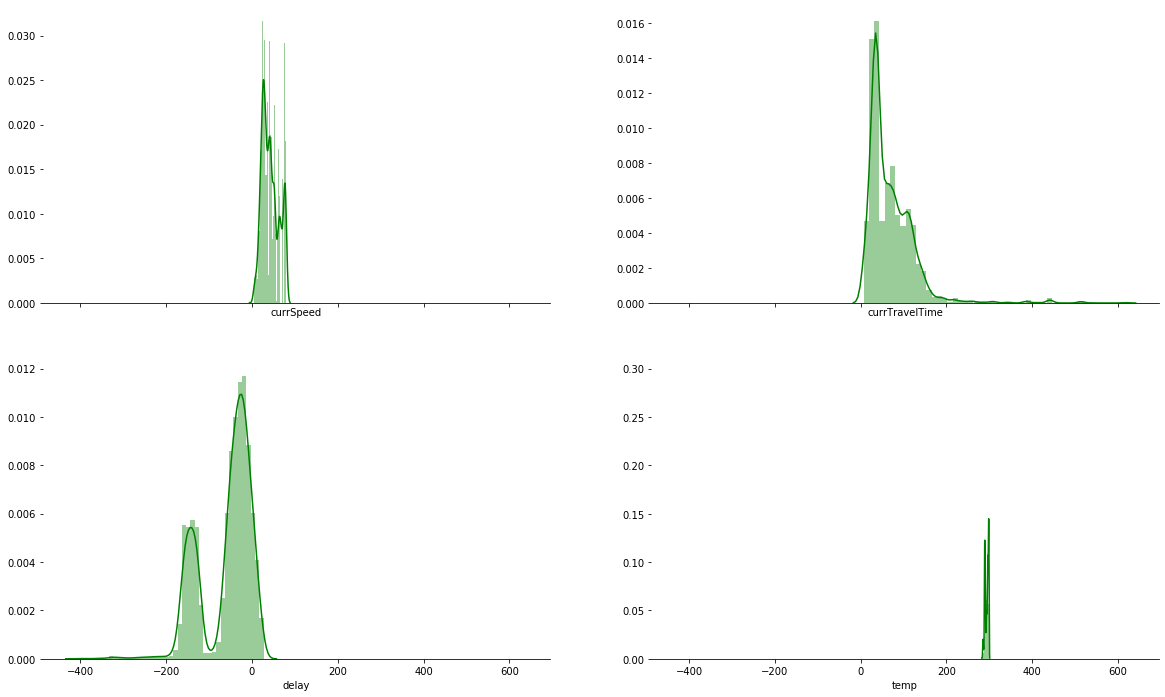

In [47]:
histograms(df, columns=['currSpeed', 'currTravelTime', 'delay', 'temp'], height=12, width=20, kde=True, color="g", multi_plot=True)

#### Histogram `delay` (przed i po czyszczeniu danych)

*  `df_without_outliners` - dane oczyszczone z wartości odstających

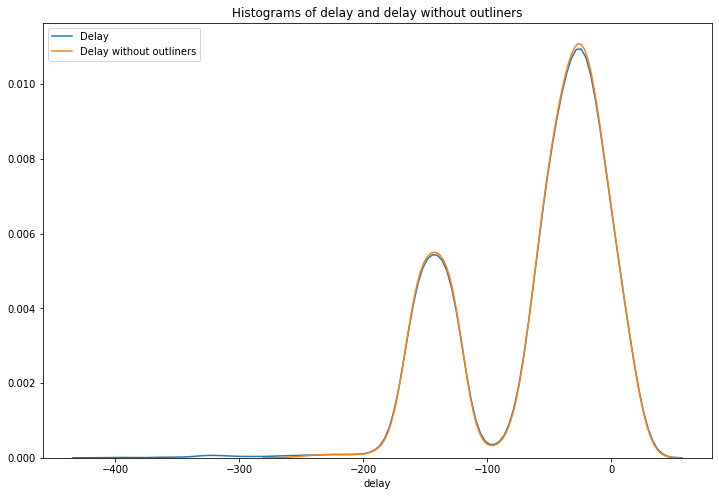

In [48]:
df_without_outliners = remove_outliers(df, columns=['delay'], error_discriminator=1.2)

plt.figure(figsize=(12,8))
sns.distplot(a=df.delay, hist=False, label="Delay")
sns.distplot(a=df_without_outliners.delay, hist=False, label="Delay without outliners")
plt.legend()
plt.title("Histograms of delay and delay without outliners")
plt.show()

#### Spóźnienia wg przystanków

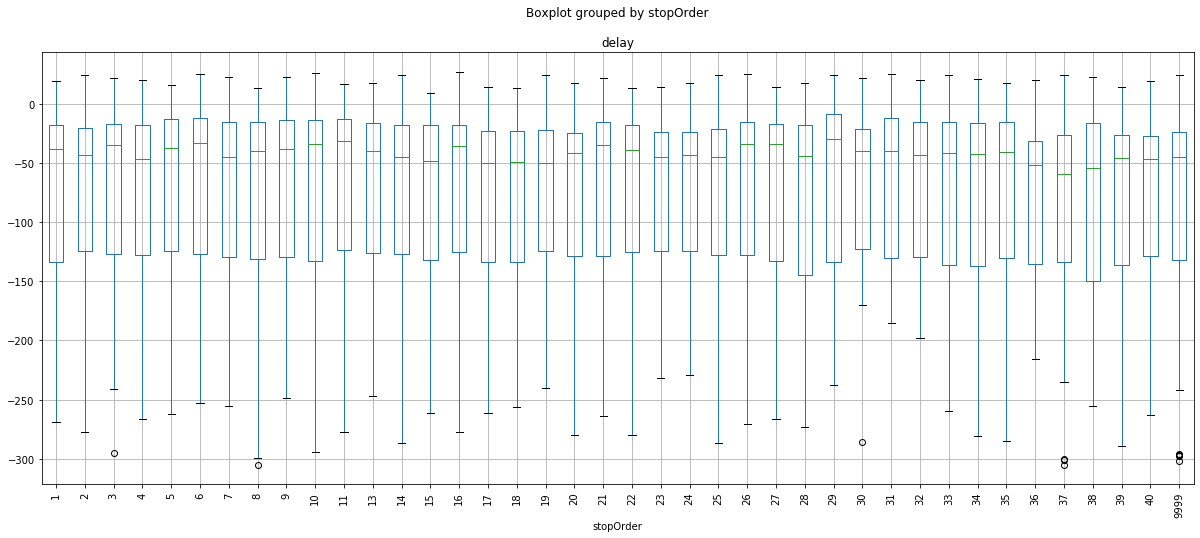

In [81]:
df_to_mydlniki = remove_outliers(df_to_mydlniki, ["delay"])

df_to_mydlniki.boxplot(by='stopOrder', column=['delay'], figsize=(20,8), rot="90")

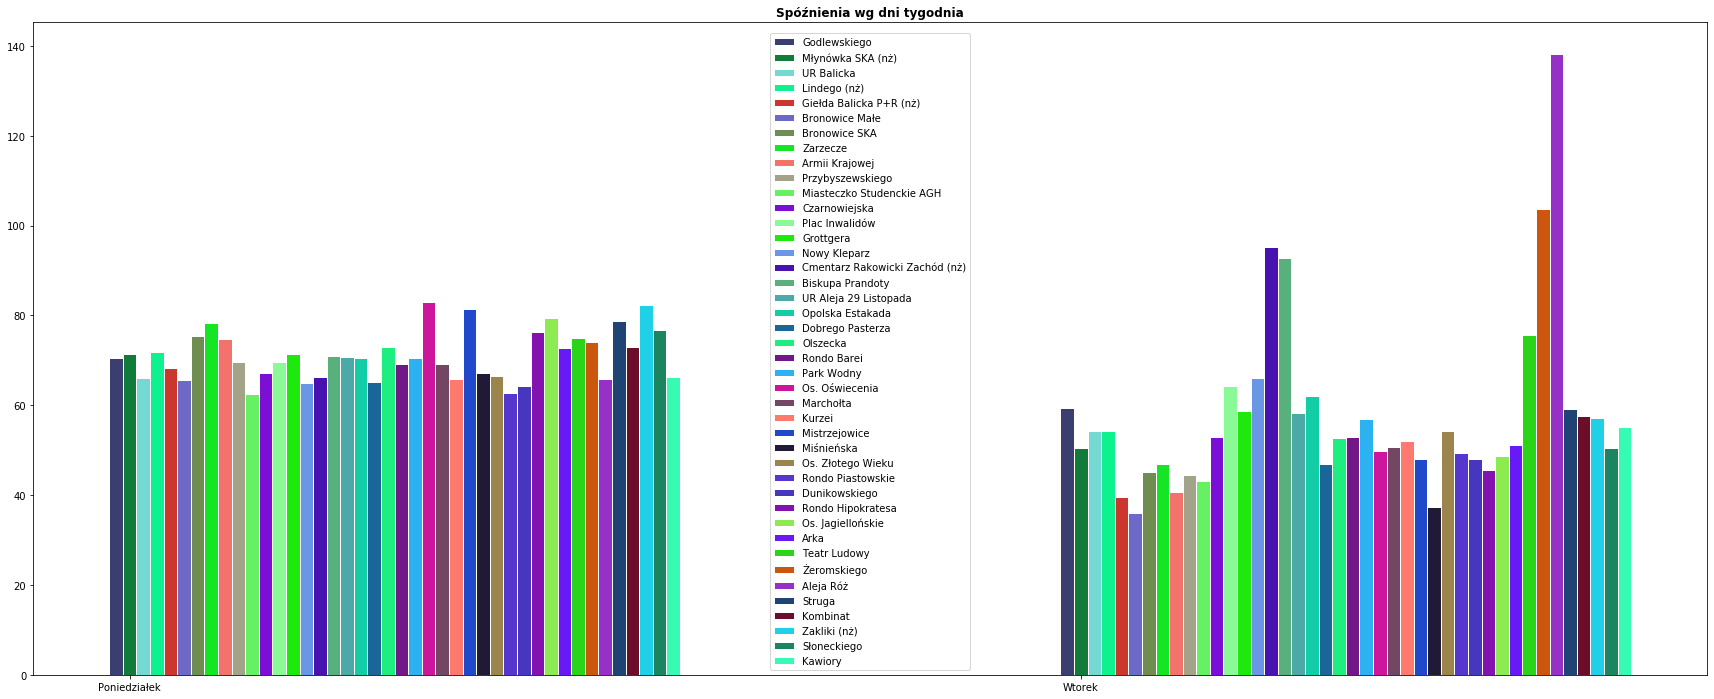

In [83]:
data_plot = df_to_mydlniki

cols = data_plot.stopName.unique()

barWidth = .6 / len(cols)

bars: List[pd.Series] = []
for i, column in enumerate(cols):
    bars.append(data_plot.groupby(['stopName', 'weekday']).mean().loc[column].delay * (-1))

rs: List[np.array] = [np.arange(len(bars[0]))]

for i in range(len(bars)-1):
    rs.append([x + barWidth for x in rs[i]])
    
plt.figure(figsize=(30,12))

r = lambda: random.randint(0,255)
cols = [(column, '#%02X%02X%02X' % (r(),r(),r())) for column in cols]
 
for i, (column, color) in enumerate(cols):
    plt.bar(rs[i], bars[i], color=color, width=barWidth, edgecolor='white', label=column)

plt.title('Spóźnienia wg dni tygodnia', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))], ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'])
 
plt.legend()
plt.show()

In [75]:
df_to_mydlniki = df_sort_by_stops_order[df_sort_by_stops_order.direction == "Mydlniki"]

In [76]:
df_to_mydlniki.shape

(4976, 16)

In [77]:
df_to_mydlniki.head()

,currSpeed,currTravelTime,date,delay,direction,patternText,plannedTime,routeId,stop,stopName,temp,tripId,unixTime,weather,weekday,stopOrder
7023,70.0,38.0,2020-07-31 19:20:00,-262,Mydlniki,139,19:20,8095257447305839175,2909,Godlewskiego,296.899994,8095261304186543118,1.596216e+09,Clear,4,1
2071,70.0,38.0,2020-07-31 08:56:00,-21,Mydlniki,139,08:56,8095257447305839175,2909,Godlewskiego,289.649994,8095261304187169796,1.596179e+09,Clouds,4,1
607,70.0,38.0,2020-07-31 06:19:00,-17,Mydlniki,139,06:19,8095257447305839175,2909,Godlewskiego,288.380005,8095261304186543108,1.596169e+09,Clouds,4,1
7378,70.0,38.0,2020-07-31 20:19:00,-123,Mydlniki,139,20:19,8095257447305839175,2909,Godlewskiego,295.350006,8095261304186547212,1.596220e+09,Clear,4,1
4039,70.0,38.0,2020-07-31 13:45:00,-140,Mydlniki,139,13:45,8095257447305839175,2909,Godlewskiego,298.079987,8095261304186551298,1.596196e+09,Clouds,4,1


In [101]:
df_to_kombinat = remove_outliers(df_to_kombinat, ["delay"])

In [103]:
df_to_mydlniki.head()

,currSpeed,currTravelTime,date,delay,direction,patternText,plannedTime,routeId,stop,stopName,temp,tripId,unixTime,weather,weekday,stopOrder,czasPomiaru
7023,70.0,38.0,2020-07-31 19:20:00,-262,Mydlniki,139,19:20,8095257447305839175,2909,Godlewskiego,296.899994,8095261304186543118,1.596216e+09,Clear,4,1,1160
2071,70.0,38.0,2020-07-31 08:56:00,-21,Mydlniki,139,08:56,8095257447305839175,2909,Godlewskiego,289.649994,8095261304187169796,1.596179e+09,Clouds,4,1,536
607,70.0,38.0,2020-07-31 06:19:00,-17,Mydlniki,139,06:19,8095257447305839175,2909,Godlewskiego,288.380005,8095261304186543108,1.596169e+09,Clouds,4,1,379
7378,70.0,38.0,2020-07-31 20:19:00,-123,Mydlniki,139,20:19,8095257447305839175,2909,Godlewskiego,295.350006,8095261304186547212,1.596220e+09,Clear,4,1,1219
4039,70.0,38.0,2020-07-31 13:45:00,-140,Mydlniki,139,13:45,8095257447305839175,2909,Godlewskiego,298.079987,8095261304186551298,1.596196e+09,Clouds,4,1,825


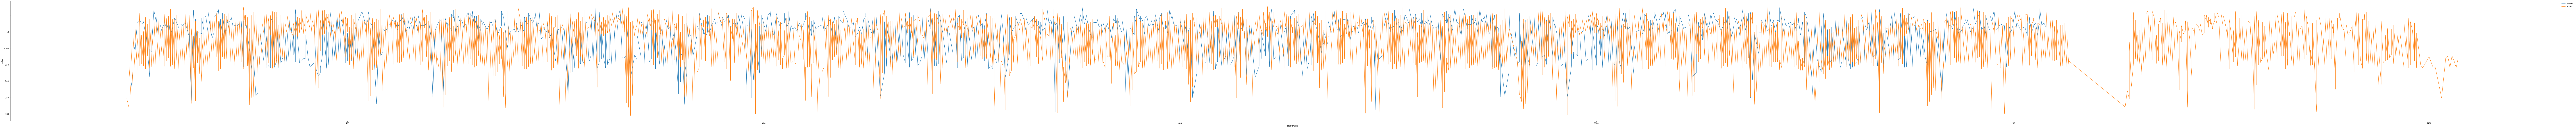

In [112]:
df_to_mydlniki['czasPomiaru'] = [ int(t[:2]) * 60 + int(t[-2:]) for t in df_to_mydlniki.plannedTime]

plt.figure(figsize=(250,12))
sns.lineplot(data=df_to_mydlniki[df_to_mydlniki.weekday == 5], x="czasPomiaru", y="delay", label="Sobota", estimator=None)
sns.lineplot(data=df_to_mydlniki[df_to_mydlniki.weekday == 4], x="czasPomiaru", y="delay", label="Piatek", estimator=None)
plt.show()

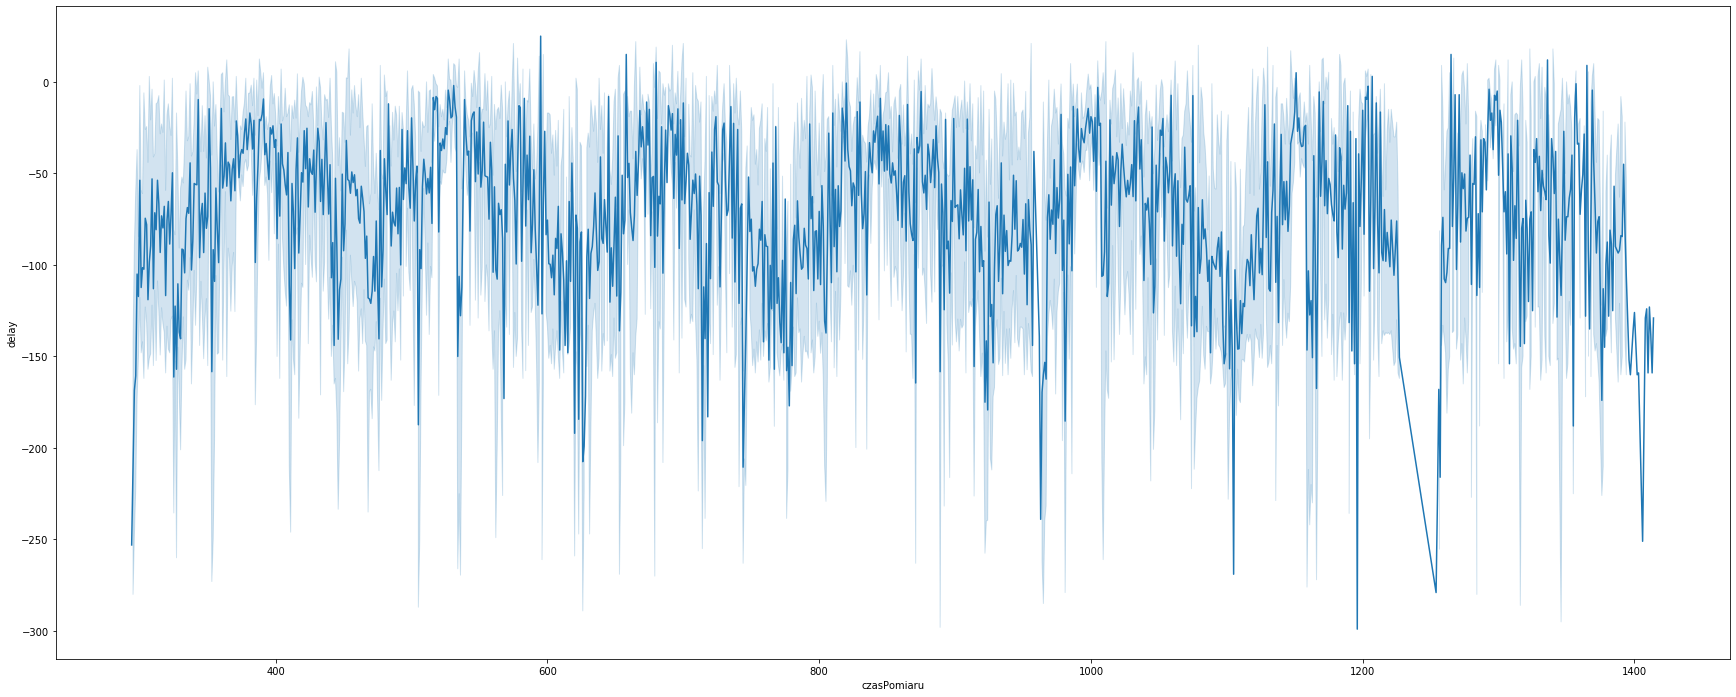

In [106]:
plt.figure(figsize=(30,12))
sns.lineplot(data=df_to_mydlniki[df_to_mydlniki.weekday == 4], x="czasPomiaru", y="delay")
plt.show()

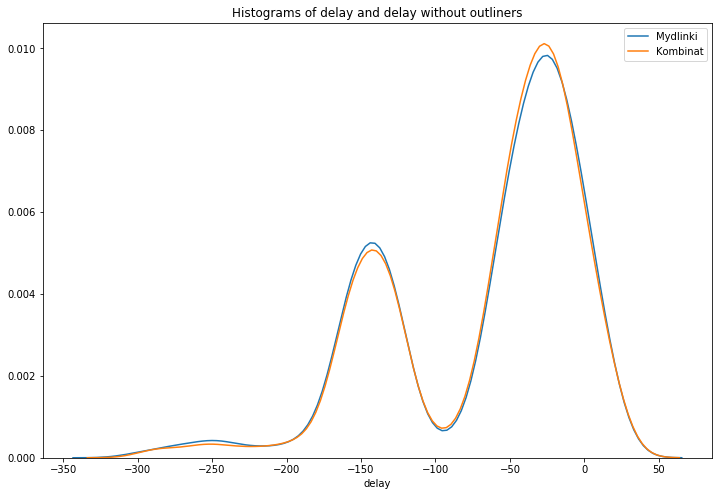

In [102]:
plt.figure(figsize=(12,8))
sns.distplot(a=df_to_mydlniki.delay, hist=False, label="Mydlinki")
sns.distplot(a=df_to_kombinat.delay, hist=False, label="Kombinat")
plt.legend()
plt.title("Histograms of delay and delay without outliners")
plt.show()